In [ ]:
# python libraries
import numpy as np
from IPython.display import HTML, display
import matplotlib.pyplot as plt

# pydrake imports
#urdf
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder,
                         LinearQuadraticRegulator, Parser, StartMeshcat,
                         PlanarSceneGraphVisualizer, Simulator, Linearize,
                         FindResourceOrThrow,
                         MeshcatVisualizerCpp, MeshcatVisualizerParams, 
                         RigidTransform, Role, RollPitchYaw, Simulator, 
                         JointSliders)

#traj_opt
from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram, JacobianWrtVariable, eq)

In [ ]:
#start visualizer
meshcat = StartMeshcat()

t=2022-05-15T22:15:13+0000 lvl=warn msg="can't bind default web address, trying alternatives" obj=web addr=127.0.0.1:4040
Meshcat is now available at http://6704-54-234-199-234.ngrok.io


In [ ]:
#Monkey bar urdf skeleton
monkey_bar = """ 
    <link name="barNUMBER">
        <inertial>
            <origin xyz="REPLACE 0 0" />
            <mass value="1" />
        </inertial>

        <visual>
            <origin xyz="REPLACE 0 0" />
            <geometry>
                <box size=".2 .2 .2" />
            </geometry>
            <material>
                <color rgba="0 0 0 1" />
            </material>
        </visual>
    </link>
"""

monkey_bar_joint = """
    <joint name="bar_jointNUMBER" type="fixed">
        <parent link="world" />
        <child link="barNUMBER" />
        <origin xyz="0 0 0" />
    </joint>
"""

In [ ]:
#monkey links
monkey_grasp_link = """
    <link name="grasp_link">
        <inertial>
            <origin xyz="0 0 -.5" />
            <mass value=".2" />
        </inertial>

        <visual>
            <origin xyz="0 0 -.5" />
            <geometry>
                <sphere radius=".05" />
            </geometry>
            <material>
                <color rgba="1 0 1 1" />
            </material>
        </visual>

        <visual>
            <origin xyz="0 0 -.5" />
            <geometry>
                <cylinder radius=".02" length="1" />
            </geometry>
            <material>
                <color rgba="0 0 1 1" />
            </material>
        </visual>
    </link>
"""

monkey_swing_link = """
    <link name="swing_link">
        <inertial>
            <origin xyz="0 0 .5" />
            <mass value=".2" />
        </inertial>

        <visual>
            <origin xyz="0 0 .5" />
            <geometry>
                <sphere radius=".05" />
            </geometry>
            <material>
                <color rgba="1 1 0 1" />
            </material>
        </visual>

        <visual>
            <origin xyz="0 0 .5" />
            <geometry>
                <cylinder radius=".02" length="1" />
            </geometry>
            <material>
                <color rgba="1 0 0 1" />
            </material>
        </visual>
    </link>
"""

In [ ]:
#monkey body base
monkey_base = """
    <link name="base">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="1" />
        </inertial>

        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <box size="0.3 0.3 0.3" />
            </geometry>
            <material>
                <color rgba="0 1 0 1" />
            </material>
        </visual>
    </link>
"""

base_joint_x = """
    <link name="floating_base_x" />

    <joint name="base_x" type="prismatic">
        <parent link="world" />
        <child link="floating_base_x" />
        <axis xyz="1 0 0" />
    </joint>
"""

base_joint_z = """
    <link name="floating_base_z" />

    <joint name="base_z" type="prismatic">
        <parent link="floating_base_x" />
        <child link="base" />
        <axis xyz="0 0 1" />
    </joint>
"""

In [ ]:
#joints
base_grasp_joint = """
    <joint name="base_grasp_joint" type="continuous">
        <parent link="base" />
        <child link="grasp_link" />
        <axis xyz="0 -1 0" />
        <origin xyz="0 0 -1" />
    </joint>
"""
monkey_joints = """
    <link name="floating_base_x" />

    <joint name="base_x" type="prismatic">
        <parent link="world" />
        <child link="floating_base_x" />
        <axis xyz="1 0 0" />
    </joint>

    <link name="floating_base_z" />

    <joint name="base_z" type="prismatic">
        <parent link="floating_base_x" />
        <child link="floating_base_z" />
        <axis xyz="0 0 1" />
    </joint>

    <joint name="grasp_joint" type="continuous">
        <parent link="floating_base_z" />
        <child link="grasp_link" />
        <axis xyz="0 -1 0" />
        <origin xyz="0 0 0" />
    </joint>

    <joint name="base_grasp_joint" type="fixed">
        <parent link="grasp_link" />
        <child link="base" />
        <origin xyz="0 0 -1" />
    </joint>

    <joint name="base_swing_joint" type="continuous">
        <parent link="base" />
        <child link="swing_link" />
        <axis xyz="0 -1 0" />
        <origin xyz="0 0 0" />
    </joint>
"""

In [ ]:
#monkey actuators

monkey_actuators = """
    <transmission type="SimpleTransmission" name="theta1">
        <actuator name="grasp_actuator" />
        <joint name="grasp_joint" />
    </transmission>

    <transmission type="SimpleTransmission" name="theta2">
        <actuator name="swing_actuator" />
        <joint name="base_swing_joint" />
    </transmission>
"""

In [ ]:
#compass gait bot urdf
compass_gait_urdf = """
<?xml version="1.0" ?>

<robot name="compass_gait">

  <!-- ground -->
  <!-- just for visualization, it is welded to world -->

  <link name="ground">

    <visual>
      <origin xyz="0 0 -.25" rpy="0 0 0"/>
      <geometry>
        <box size="10 1 .5" />
      </geometry>
      <material name="green">
        <color rgba="0 1 0 1" />
      </material>
    </visual>

  </link>

  <joint name="ground_is_world" type="fixed">

    <parent link="world" />
    <child link="ground" />
    <!-- slope of the ramp here -->
    <origin xyz="0 0 0" rpy="0 .04 0"/>

  </joint>

  <!-- floating base for stance foot -->

  <link name="floating_base_x" />

  <joint name="floating_base_x" type="prismatic">

    <parent link="ground"/>
    <child link="floating_base_x"/>
    <axis xyz="1 0 0"/>

  </joint>

  <link name="floating_base_z" />

  <joint name="floating_base_z" type="prismatic">

    <parent link="floating_base_x"/>
    <child link="floating_base_z"/>
    <axis xyz="0 0 1"/>

  </joint>

  <!-- stance leg -->

  <link name="stance_leg">

    <inertial>
      <origin xyz="0 0 .5"/>
      <mass value=".1"/>
    </inertial>

    <visual>
      <origin xyz="0 0 .5"/>
      <geometry>
        <sphere radius=".05"/>
      </geometry>
      <material>
        <color rgba="1 0 0 1"/>
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 .5"/>
      <geometry>
        <cylinder length="1" radius=".01"/>
      </geometry>
      <material>
        <color rgba="1 0 0 1"/>
      </material>
    </visual>

  </link>

  <joint name="floating_base_y" type="continuous">

    <parent link="floating_base_z"/>
    <child link="stance_leg"/>
    <axis xyz="0 -1 0"/>

  </joint>

  <!-- body, welded to stance leg -->

  <link name="body">

    <inertial>
      <origin xyz="0 0 1"/>
      <mass value="1"/>
    </inertial>

    <visual>
      <origin xyz="0 0 0"/>
      <geometry>
        <sphere radius=".1"/>
      </geometry>
      <material>
        <color rgba="1 1 1 1"/>
      </material>
    </visual>

  </link>

  <joint name="body_on_stance_leg" type="fixed">

    <parent link="stance_leg" />
    <child link="body" />
    <origin xyz="0 0 1"/>

  </joint>

  <!-- swing leg -->

  <link name="swing_leg">

    <inertial>
      <origin xyz="0 0 -.5"/>
      <mass value=".1"/>
    </inertial>

    <visual>
      <origin xyz="0 0 -.5"/>
      <geometry>
        <sphere radius=".05"/>
      </geometry>
      <material>
        <color rgba="0 0 1 1"/>
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 -.5"/>
      <geometry>
        <cylinder length="1" radius=".01"/>
      </geometry>
      <material>
        <color rgba="0 0 1 1"/>
      </material>
    </visual>

  </link>

  <joint name="hip_pin" type="continuous">

    <parent link="body"/>
    <child link="swing_leg"/>
    <axis xyz="0 -1 0"/>

  </joint>

</robot>
"""

In [ ]:
def create_monkey_urdf(bar_params, link_params=None):
    #bar params is [0, b_0, b_c]
    
    #urdf header and ender
    urdf = """<?xml version="1.0"?>\n<robot name="BattleMonkey">BASE</robot>"""
    # cart base of the robot
    urdf = urdf.replace("BASE", monkey_base + "BAR")

    for i in range(3):
        bar_x = bar_params[i]
        if i == 1:
            bar_x = -bar_x #bar1 is behind bar0
        urdf = urdf.replace("BAR", monkey_bar.replace("NUMBER", str(i)).replace("REPLACE", str(bar_x), 2) + "BAR")
    urdf = urdf.replace("BAR", monkey_grasp_link + "BAR")
    urdf = urdf.replace("BAR", monkey_swing_link + "JOINT")
    #urdf = urdf.replace("BAR", "JOINT")

    for i in range(3):
        urdf = urdf.replace("JOINT", monkey_bar_joint.replace("NUMBER", str(i), 2) + "JOINT")
    
    #urdf = urdf.replace("JOINT", base_joint_x + "JOINT")
    #urdf = urdf.replace("JOINT", base_joint_z)
    urdf = urdf.replace("JOINT", monkey_joints + "ACTS")
    urdf = urdf.replace("ACTS", monkey_actuators)

    return urdf

In [ ]:
#create urdf
bar_params = [0, 1, 1]
monkey_urdf = create_monkey_urdf(bar_params)
print(monkey_urdf)

<?xml version="1.0"?>
<robot name="BattleMonkey">
    <link name="base">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="1" />
        </inertial>

        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <box size="0.3 0.3 0.3" />
            </geometry>
            <material>
                <color rgba="0 1 0 1" />
            </material>
        </visual>
    </link>
 
    <link name="bar0">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="1" />
        </inertial>

        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <box size=".2 .2 .2" />
            </geometry>
            <material>
                <color rgba="0 0 0 1" />
            </material>
        </visual>
    </link>
 
    <link name="bar1">
        <inertial>
            <origin xyz="-1 0 0" />
            <mass value="1" />
        </inertial>

        <visual>
            <origin xyz=

In [ ]:
meshcat.Delete()
meshcat.DeleteAddedControls()
builder = DiagramBuilder()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)

# Load the file into the plant/scene_graph.
parser = Parser(plant)
#for name, directory in package_paths.items():
#    parser.package_map().Add(name, directory)
parser.AddModelFromString(monkey_urdf, "urdf")
#parser.AddModelFromString(compass_gait_urdf, "urdf")

plant.Finalize()

# Add two visualizers, one to publish the "visual" geometry, and one to
# publish the "collision" geometry.
visual = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat,
    MeshcatVisualizerParams(role=Role.kPerception, prefix="visual"))
#collision = MeshcatVisualizerCpp.AddToBuilder(
#    builder, scene_graph, meshcat,
#    MeshcatVisualizerParams(role=Role.kProximity, prefix="collision"))
# Disable the collision geometry at the start; it can be enabled by the
# checkbox in the meshcat controls.
#meshcat.SetProperty("collision", "visible", False)

sliders = builder.AddSystem(JointSliders(meshcat, plant))

diagram = builder.Build()
#sliders.Run(diagram)

In [ ]:
#friction coeff b/w hand and bar
friction = 0.2 #do we even need friction?

# position of the hand in the respective arm frame
# (must match the urdf)
hand_in_arm = {
    'grasp_link': np.zeros(3),        # grasp hand in grasp link frame
    'swing_link': np.array([0, 0, 1]) # swing hand in swing link frame
}

# parse urdf and create the MultibodyPlant
battle_monkey = MultibodyPlant(time_step=0)
Parser(battle_monkey).AddModelFromString(monkey_urdf, "urdf")
battle_monkey.Finalize()

# overwrite MultibodyPlant with its autodiff copy
battle_monkey = battle_monkey.ToAutoDiffXd()

# number of configuration variables
nq = battle_monkey.num_positions()
print(nq)

# number of actuators
nu = battle_monkey.num_actuators()
print(nu)

# number of components of the contact forces
nf = 2

4
2


In [ ]:
# Function that given the current configuration, velocity,
# acceleration, contact force at the grasp hand, and control inputs, evaluates
# the manipulator equations. The output of this function is a
# vector with dimensions equal to the number of configuration
# variables. If the output of this function is equal to zero
# then the given arguments verify the manipulator equations.
def manipulator_equations(vars):
    
    # split input vector in subvariables
    # configuration, velocity, acceleration, stance-foot force
    assert vars.size == 3 * nq + nf + nu
    split_at = [nq, 2 * nq, 3 * nq, 3*nq+nf]
    q, qd, qdd, f, u = np.split(vars, split_at)
    
    # set compass gait state
    context = battle_monkey.CreateDefaultContext()
    battle_monkey.SetPositions(context, q)
    battle_monkey.SetVelocities(context, qd)
    
    # matrices for the manipulator equations
    M = battle_monkey.CalcMassMatrixViaInverseDynamics(context)
    Cv = battle_monkey.CalcBiasTerm(context)
    tauG = battle_monkey.CalcGravityGeneralizedForces(context)
    B = battle_monkey.MakeActuationMatrix()
    
    # Jacobian of the grasp hand
    J = get_hand_jacobian(battle_monkey, context, 'grasp_link', 'bar1')
    
    # return violation of the manipulator equations
    return M.dot(qdd) + Cv - tauG - J.T.dot(f) - B.dot(u)

# Function that given the current configuration, returns
# the distance of the swing foot from bar2, the right-most bar (scalar).
# We have penetration if the output x component is close to 0 and
# the z component is negative.
def swing_hand_height(q):
    
    # get reference frames for the swing leg and the ground
    swing_link_frame = battle_monkey.GetBodyByName('swing_link').body_frame()
    dists = []
    for bar in ['bar0', 'bar2']:
        bar_frame = battle_monkey.GetBodyByName(bar).body_frame()
        
        # position of the swing foot in ground coordinates
        context = battle_monkey.CreateDefaultContext()
        battle_monkey.SetPositions(context, q)
        swing_hand_position = battle_monkey.CalcPointsPositions(
            context,
            swing_link_frame,
            hand_in_arm['swing_link'],
            bar_frame
        )
        dists.append(swing_hand_position[-1])
    
    #make sure the swing hand is near the bar2 
    #before caring about if it has collided w bar2
    #if abs(swing_hand_position[0]) > 0.25:
    #    return abs(swing_hand_position[-1])
    return np.concatenate((dists[0], dists[1]))

# Function that implements the impulsive collision derived in
# the textbook appendix. Arguments are: battle monkey configuration,
# velocities before and after heel strike, and the swing-hand
# impulse (in latex, $\int_{t_c^-}^{t_c^+} \lambda dt$).
# Returns a vector of quantities that must vanish in order
# for the impulsive dynamics to be verified: it enforces the velocity
# jump due to the impulse, and the inelastic behavior of the
# collision (zero coefficient of restitution $e$).
# See http://underactuated.mit.edu/multibody.html#impulsive_collision
def reset_velocity_newgrasp(vars):
    
    # split input vector in subvariables
    # qd_pre: generalized velocity before the new grasp
    # qd_post: generalized velocity after the new grasp
    # imp: swing-hand collision impulse (2d vector)
    assert vars.size == 3 * nq + nf
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd_pre, qd_post, imp = np.split(vars, split_at)

    # set compass gait configuration
    context = battle_monkey.CreateDefaultContext()
    battle_monkey.SetPositions(context, q)
    
    # get necessary matrices
    M = battle_monkey.CalcMassMatrixViaInverseDynamics(context)
    J = get_hand_jacobian(battle_monkey, context, 'swing_link', 'bar2')
    
    # return a vector that must vanish for the impulsive dynamics to hold
    return np.concatenate((
        M.dot(qd_post - qd_pre) - J.T.dot(imp), # velocity jump due to the impulse
        J.dot(qd_post)                          # zero velocity restitution
    ))

# Function that given an arm, returns the Jacobian matrix for the related hand.
def get_hand_jacobian(battle_monkey, context, arm, bar):
    
    # get reference frames for the given leg and the ground
    arm_frame = battle_monkey.GetBodyByName(arm).body_frame()
    bar_frame = battle_monkey.GetBodyByName(bar).body_frame()

    # compute Jacobian matrix
    #changed so that you can get the jacobian for the right bar
    #as well as the right hand/arm
    J = battle_monkey.CalcJacobianTranslationalVelocity(
        context,
        JacobianWrtVariable(0),
        arm_frame,
        hand_in_arm[arm],
        bar_frame,
        bar_frame
    )
    
    # discard y components since we are in 2D
    return J[[0, 2]]

In [ ]:
#making variable for trajectory optimization

# time steps in the trajectory optimization
T = 50

# minimum and maximum time interval is seconds
h_min = .005
h_max = .05

# initialize program
prog = MathematicalProgram()

# vector of the time intervals
# (distances between the T + 1 break points)
h = prog.NewContinuousVariables(T, name='h')

# system configuration, generalized velocities, and accelerations
q = prog.NewContinuousVariables(rows=T+1, cols=nq, name='q')
qd = prog.NewContinuousVariables(rows=T+1, cols=nq, name='qd')
qdd = prog.NewContinuousVariables(rows=T, cols=nq, name='qdd')

# inputs
u = prog.NewContinuousVariables(rows=T, cols=nu, name='u')

# grasp hand force
f = prog.NewContinuousVariables(rows=T, cols=nf, name='f')

# impulse for the swing arm
imp = prog.NewContinuousVariables(nf, name='imp')

# generalized velocity after the heel strike
# (if "mirrored", this velocity must coincide with the
# initial velocity qd[0] to ensure periodicity)
qd_post = prog.NewContinuousVariables(nq, name='qd_post')

In [ ]:
# lower and upper bound on the time steps for all t
prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

# link the configurations, velocities, and accelerations
# uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
for t in range(T):
    prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
    prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

# manipulator equations for all t (implicit Euler)
for t in range(T):
    vars = np.concatenate((q[t+1], qd[t+1], qdd[t], f[t], u[t]))
    prog.AddConstraint(manipulator_equations, lb=[0]*nq, ub=[0]*nq, vars=vars)
    
# velocity reset across heel strike
# see http://underactuated.mit.edu/multibody.html#impulsive_collision
vars = np.concatenate((q[-1], qd[-1], qd_post, imp))
prog.AddConstraint(reset_velocity_newgrasp, lb=[0]*(nq+nf), ub=[0]*(nq+nf), vars=vars)
    
# mirror initial and final configuration
#prog.AddLinearConstraint(eq(q[0], - q[-1]))

# mirror constraint between initial and final velocity
# see "The Walking Cycle" section of this notebook
prog.AddLinearConstraint(qd[0, 0] == 0)
prog.AddLinearConstraint(qd[0, 1] == 0)
prog.AddLinearConstraint(qd[0, 2] == qd_post[2] + qd_post[3])
prog.AddLinearConstraint(qd[0, 3] == - qd_post[3])


# 1. grasp hand on bar0 for all times
for t in range(T+1):
    prog.AddLinearConstraint(q[t, 0] == 0)
    prog.AddLinearConstraint(q[t, 1] == 0)

# 2. swing grasp on bar1 at time zero
#equation will change depending on arm link length
prog.AddLinearConstraint(q[0, 2] == -np.arcsin(bar_params[1]/2))
prog.AddLinearConstraint(q[0, 3] == -2*(q[0, 2]))

# 3. swing grasp on bar2 at tf
#equation will change depending on arm link length
prog.AddLinearConstraint(q[-1, 2] == np.arcsin(bar_params[2]/2))
prog.AddLinearConstraint(q[-1, 3] == -2*(q[-1, 2]))

# 4. no penetration of the swing hand in bar2 for times 1 to T-1
for t in range(1,T-1):
    prog.AddConstraint(swing_hand_height, lb=[-np.inf]*2, ub=[0]*2, vars=q[t])

# 5. add cost of u to use less actuation
total = 0
for t in range(T):
    total += u[t, 0]**2 + u[t, 1]**2
prog.AddCost(total)

'''
# 4. stance-foot contact force in friction cone for all times
for t in range(T):
    prog.AddLinearConstraint(f[t, 1] >= 0)
    prog.AddLinearConstraint(f[t, 0] <= friction*f[t, 1])
    prog.AddLinearConstraint(f[t, 0] >= -friction*f[t, 1])

# 5. swing-foot impulse in friction cone
prog.AddLinearConstraint(imp[1] >= 0)
prog.AddLinearConstraint(imp[0] <= friction*imp[1])
prog.AddLinearConstraint(imp[0] >= -friction*imp[1])
'''

'\n# 4. stance-foot contact force in friction cone for all times\nfor t in range(T):\n    prog.AddLinearConstraint(f[t, 1] >= 0)\n    prog.AddLinearConstraint(f[t, 0] <= friction*f[t, 1])\n    prog.AddLinearConstraint(f[t, 0] >= -friction*f[t, 1])\n\n# 5. swing-foot impulse in friction cone\nprog.AddLinearConstraint(imp[1] >= 0)\nprog.AddLinearConstraint(imp[0] <= friction*imp[1])\nprog.AddLinearConstraint(imp[0] >= -friction*imp[1])\n'

In [ ]:
# vector of the initial guess
initial_guess = np.ones(prog.num_vars())

# initial guess for the time step
h_guess = h_max
prog.SetDecisionVariableValueInVector(h, [h_guess] * T, initial_guess)

# linear interpolation of the configuration
theta1_0 = -np.arcsin(bar_params[1]/2)
theta2_0 = -2*theta1_0
theta1_f = np.arcsin(bar_params[2]/2)
theta2_f = -2*theta1_f
q0_guess = np.array([0, 0, theta1_0, theta2_0])
qf_guess = np.array([0, 0, theta1_f, theta2_f])
q_guess_poly = PiecewisePolynomial.FirstOrderHold(
    [0, T * h_guess],
    np.column_stack((q0_guess, qf_guess))
)
qd_guess_poly = q_guess_poly.derivative()
qdd_guess_poly = qd_guess_poly.derivative()

# set initial guess for configuration, velocity, and acceleration
q_guess = np.hstack([q_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
qd_guess = np.hstack([qd_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
qdd_guess = np.hstack([qdd_guess_poly.value(t * h_guess) for t in range(T)]).T
prog.SetDecisionVariableValueInVector(q, q_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qd, qd_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qdd, qdd_guess, initial_guess)

# initial guess for the normal component of the stance-leg force
bodies = ['base', 'grasp_link', 'swing_link']
mass = sum(battle_monkey.GetBodyByName(body).default_mass() for body in bodies)
g = - battle_monkey.gravity_field().gravity_vector()[-1]
weight = mass * g
prog.SetDecisionVariableValueInVector(f[:, 1], [weight] * T, initial_guess)

# solve mathematical program with initial guess
solver = SnoptSolver()
result = solver.Solve(prog, initial_guess)

# ensure solution is found
print(f'Solution found? {result.is_success()}.')

Solution found? True.


In [ ]:
# get optimal solution
h_opt = result.GetSolution(h)
q_opt = result.GetSolution(q)
qd_opt = result.GetSolution(qd)
qdd_opt = result.GetSolution(qdd)
u_opt = result.GetSolution(u)
f_opt = result.GetSolution(f)
imp_opt = result.GetSolution(imp)
qd_post_opt = result.GetSolution(qd_post)
'''
#cycle 2
q_opt_2 = np.copy(q_opt)
q_opt_2[:, 0] = bar_params[2]
q_opt_2[:, 2] = q_opt[:, 2] + q_opt[:, 3]
q_opt_2[:, 3] = 2*np.pi - q_opt[:, 3]
q_opt_2 = q_opt_2[1:, :]

qd_opt_2 = np.copy(qd_opt)
qd_opt_2[:, 2] = qd_opt[:, 2] + qd_opt[:, 3]
qd_opt_2[:, 3] = -qd_opt[:, 3]
qd_opt_2 = qd_opt_2[1:, :]

h_opt_2 = np.copy(h_opt)

q_opt_full = np.concatenate((q_opt, q_opt_2), axis=0)
qd_opt_full = np.concatenate((qd_opt, qd_opt_2), axis=0)
h_opt_full = np.concatenate((h_opt, h_opt_2), axis=0)
'''
# stack states
x_opt = np.hstack((q_opt, qd_opt))

# interpolate state values for animation
time_breaks_opt = np.array([sum(h_opt[:t]) for t in range(T+1)])

x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_opt.T)

# parse urdf with scene graph
battle_monkey = MultibodyPlant(time_step=0)
scene_graph = SceneGraph()
battle_monkey.RegisterAsSourceForSceneGraph(scene_graph)
Parser(battle_monkey).AddModelFromString(monkey_urdf, "urdf")
battle_monkey.Finalize()

# build block diagram and drive system state with
# the trajectory from the optimization problem
builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_opt_poly))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(battle_monkey, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(battle_monkey.get_source_id()))

# add visualizer
xlim = [-2, 3]
ylim = [-2, .5]
visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False))
builder.Connect(scene_graph.get_query_output_port(),
                visualizer.get_input_port(0))
simulator = Simulator(builder.Build())

# generate and display animation
visualizer.start_recording()
simulator.AdvanceTo(x_opt_poly.end_time())
ani = visualizer.get_recording_as_animation()
HTML(ani.to_jshtml())

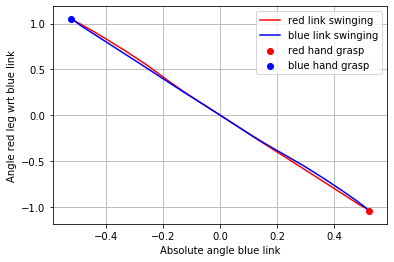

In [ ]:
# plot swing trajectories
# the second is the mirrored one
plt.plot(q_opt[:, 2], q_opt[:, 3], color='r', label='red link swinging')

plt.plot(q_opt[:, 2] + q_opt[:, 3],
         -q_opt[:, 3],
         color='b',
         label='blue link swinging')
'''
under_pi = q_opt[:, 3] < np.pi
split = np.where(under_pi==0)[0][0]
x1 = q_opt[:split, 2] + q_opt[:split, 3]
y1 = 2*np.pi-q_opt[:split, 3]
plt.plot(x1,
         y1,
         color='b',
         label='blue link swinging')

x2 = q_opt[split:, 2] + q_opt[split:, 3] #- 2*np.pi
y2 = 2*np.pi-q_opt[split:, 3]
plt.plot(x2,
         y2,
         color='b',
         label='blue link swinging',
         linestyle='dashed')
'''
# scatter heel strikes
plt.scatter(q_opt[0, 2] + q_opt[0, 3],
            -q_opt[0, 3],
            color='r',
            zorder=3,
            label='red hand grasp')
plt.scatter(q_opt[-1, 2] + q_opt[-1, 3],
            -q_opt[-1, 3],
            color='b',
            zorder=3,
            label='blue hand grasp')

# misc options
plt.xlabel('Absolute angle blue link')
plt.ylabel('Angle red leg wrt blue link')
plt.grid(True)
plt.legend()

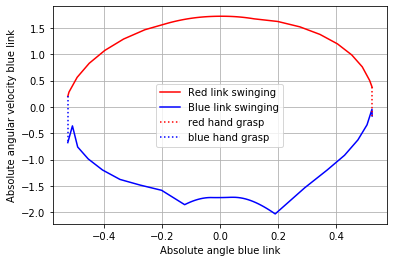

In [ ]:
# plot swing trajectories
# the second is the mirrored one
plt.plot(q_opt[:, 2], qd_opt[:, 2], color='r', label='Red link swinging')
plt.plot(q_opt[:, 2] + q_opt[:, 3], qd_opt[:, 2] + qd_opt[:, 3], color='b', label='Blue link swinging')

# plot heel strikes
plt.plot(
    [q_opt[-1, 2], q_opt[0, 2] + q_opt[0, 3]],
    [qd_opt[-1, 2], qd_opt[0, 2] + qd_opt[0, 3]],
    linestyle=':',
    color='r',
    label='red hand grasp'
)
plt.plot(
    [q_opt[0, 2], q_opt[-1, 2] + q_opt[-1, 3]],
    [qd_opt[0, 2], qd_opt[-1, 2] + qd_opt[-1, 3]],
    linestyle=':',
    color='b',
    label='blue hand grasp'
)

# misc options
plt.xlabel('Absolute angle blue link')
plt.ylabel('Absolute angular velocity blue link')
plt.grid(True)
plt.legend()

24.06111465917139


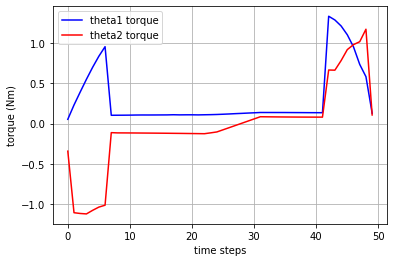

In [ ]:
# plot inputs
plt.plot(range(len(u_opt)), u_opt[:, 0], label="theta1 torque", color="blue")
plt.plot(range(len(u_opt)), u_opt[:, 1], label="theta2 torque", color="red")

plt.xlabel('time steps')
plt.ylabel('torque (Nm)')
plt.grid(True)
plt.legend()

cost_opt = 0
for t in range(T):
    cost_opt += u_opt[t, 0]**2 + u_opt[t, 1]**2
print(cost_opt)

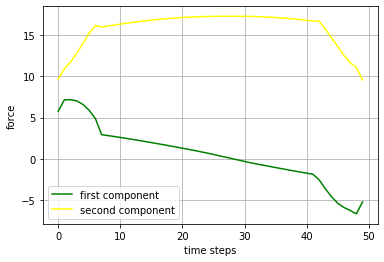

In [ ]:
plt.plot(range(len(f_opt)), f_opt[:, 0], label="first component", color="green")
plt.plot(range(len(f_opt)), f_opt[:, 1], label="second component", color="yellow")

plt.xlabel('time steps')
plt.ylabel('force')
plt.grid(True)
plt.legend()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f68aa2bd-d5e5-4beb-aa3e-489f3e8c3132' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>